# Example: Fake Injection

Author: Shu Liu

This notebook shows how to use the fake injection framework(`/framework/fake_injection_framework.ipynb`) to perform efficiency analysis. Users are recommended to read `fake_injection_framework.ipynb` before reading this notebook.

In [59]:
import os

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from lsst.daf.persistence import Butler

import injection_utils as iu

## Injection

We want to inject fakes with magnitude 16, 16.5, 17,..., 23.5, 24 onto regions near stars (about 25 pixels away from the star, both in x and y). Stars' magnitudes are selected from the following intervals: `16 - 18`, `18 - 20`, `20 - 21`, `21 - 22`, `22 - 23`, `23 - 24`. The information of these stars are saved in check tables. For example, stars with magnitude between `21 - 22` are saved in `check22_offset_25.txt`, and stars with magnitude between `23 - 24` are saved in `check24_offset_25.txt`. The injected position is saved as `base_NaiveCentroid_x` and `base_NaiveCentroid_y` in the table.

To begin with, we need to create some empty repos for injection.

In [1]:
# create a script to make empty repos for injection
with open(f'./make_perfect_25_offset_repo.txt', "w+") as file:
    file.write('#！/bin/bash\n\n')
    for mag in [18, 20, 21, 22, 23, 24]:
        for i in range(160, 245, 5):
            line = 'cp -r /global/cfs/cdirs/desc-sn/dia/data/shl159/shared_space/fake_injection/empty_calexp_repo /global/cfs/cdirs/desc-sn/dia/data/shl159/shared_space/fake_injection/fake_data/perfect_25_offset/fake_{}_{}\n'.format(mag, i)
            file.write(line)

In [51]:
# run the script
! source ./make_perfect_25_offset_repo.txt

Then inject fakes.

In [3]:
# setup data id
tract, patch, filt = 4639, '0,0', 'r'
visit, detector = 181868, 57
calexp_id = {'visit': visit, 'detector': detector, 'filter': filt}

In [4]:
table_dir = '/global/cfs/cdirs/desc-sn/dia/data/shl159/shared_space/fake_injection/star_table'
table_pattern = 'check{}_offset_25.txt'

fake_dir = '/global/cfs/cdirs/desc-sn/dia/data/shl159/shared_space/fake_injection/fake_data/perfect_25_offset'
fake_pattern = 'fake_{}_{}'

In [54]:
# make injection
for host_mag in [18, 20, 21, 22, 23, 24]:
    injection_table_path = os.path.join(table_dir, table_pattern.format(host_mag))
    injection_table = Table.read(injection_table_path, format='ascii')
    injection_list = []
    for row in injection_table:
        x, y = row['base_NaiveCentroid_x'], row['base_NaiveCentroid_y']
        injection_list.append([x, y])
    for fake_mag in range(160, 245, 5):
        # convert fake_mag to the injected value
        injected_mag = fake_mag * 0.1
        calexp_repo = os.path.join(fake_dir, fake_pattern.format(host_mag, fake_mag))
        iu.inject_fakes_to_calexp(calexp_repo, calexp_id, injected_mag, injection_list, poisson=False)
print('done')

done


## Subtraction

After fake injection, we can run image subtraction on those images.

In [24]:
# create a script for subtraction
with open(f'./diff_perfect_25_offset.sh', "w+") as file:
    file.write('#！/bin/bash\n\n')
    for host_mag in [18, 20, 21, 22, 23, 24]:
        for fake_mag in range(160, 245, 5):
            line = 'imageDifferenceDriver.py /global/cfs/cdirs/desc-sn/dia/data/shl159/shared_space/fake_injection/fake_data/perfect_25_offset/fake_{}_{} \\\n'.format(host_mag, fake_mag)
            file.write(line)
            line2 = '    --output /global/cfs/cdirs/desc-sn/dia/data/shl159/shared_space/fake_injection/fake_data/perfect_25_offset/al_{}_{}_offset \\\n'.format(host_mag, fake_mag)
            file.write(line2)
            line3 = '    --id visit=181868 detector=57  -C diffimConfig_al.py \\\n'
            file.write(line3)
            line4 = '    --clobber-config --clobber-versions --cores 4\n'
            file.write(line4)

Run `diff_perfect_25_offset.sh` in terminal. Then we have difference images.

## Analysis

For analysis, we plot the efficiency plot, flux scatter, flux residuals, and nomalized flux difference.

In [6]:
diff_dir = '/global/cfs/cdirs/desc-sn/dia/data/shl159/shared_space/fake_injection/fake_data/perfect_25_offset'
diff_pattern = 'al_{}_{}_offset'

In [16]:
# calculate efficiency
half_width = 4
# fake_mag_array represents fake magnitudes (16, 16.5, 17,..., 23.5, 24)
fake_mag_array = np.arange(160, 245, 5)
fake_len = len(fake_mag_array)
efficiency_list = []
flux_list = []
for host_mag in [18, 20, 21, 22, 23, 24]:
    efficiency = np.zeros(fake_len)
    
    injection_table_path = os.path.join(table_dir, table_pattern.format(host_mag))
    injection_table = Table.read(injection_table_path, format='ascii')
    injection_list = iu.get_pix_coord_from_src(injection_table)

    for i, fake_mag in enumerate(fake_mag_array):
        # convert fake_mag to the injected value
        injected_mag = fake_mag * 0.1
        
        repo = os.path.join(diff_dir, diff_pattern.format(host_mag, fake_mag))
        butler = Butler(repo)
        src_table = butler.get('deepDiff_diaSrc', dataId=calexp_id)
        src_astropy = src_table.asAstropy()
        
        dia_calib = butler.get('deepDiff_differenceExp_photoCalib', dataId=calexp_id)
        flux = dia_calib.magnitudeToInstFlux(injected_mag)
        
        diff_detected, diff_missed, dia_list = iu.check_diaSrc_detecion(injection_list, src_astropy, half_width=half_width)
        efficiency[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))
        
        for i in range(len(dia_list)):
            if len(dia_list[i]) == 0 or len(dia_list[i]) > 1:
                continue
            flux_triplet = [
                flux, dia_list[i][0]['base_PsfFlux_instFlux'], dia_list[i][0]['base_PsfFlux_instFluxErr']
            ]
            flux_list.append(flux_triplet)
    efficiency_list.append(efficiency)


In [17]:
efficiency_name = 'eff_perfect_25_offset'
flux_name = 'flux_perfect_25_offset'

In [18]:
efficiency_array = np.array(efficiency_list)
flux_array = np.array(flux_list)
flux_array = flux_array.transpose()

np.save(os.path.join(diff_dir, efficiency_name), efficiency_array)
np.save(os.path.join(diff_dir, flux_name), flux_array)

In [55]:
# 0.1 is used to convert fake_mag to the injected value
injected_mag_array = fake_mag_array * 0.1

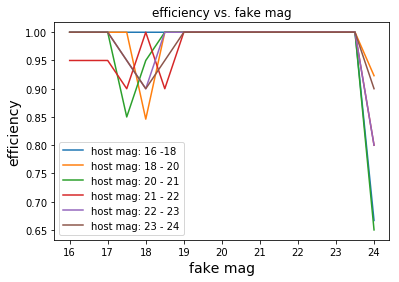

In [56]:
LABEL_LIST = ['host mag: 16 -18', 'host mag: 18 - 20', 'host mag: 20 - 21',
              'host mag: 21 - 22', 'host mag: 22 - 23', 'host mag: 23 - 24']
for i in range(len(efficiency_array)):
    plt.plot(injected_mag_array, efficiency_array[i], label=LABEL_LIST[i])
    plt.xlabel('fake mag', size=14)
    plt.ylabel('efficiency', size=14)
    plt.title('efficiency vs. fake mag')
plt.legend()

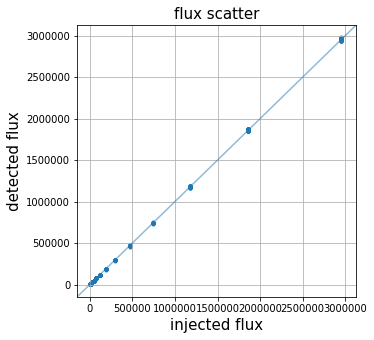

In [24]:
fig, ax = plt.subplots(figsize=((5,5)))
ax.scatter(flux_array[0], flux_array[1], marker='.')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]
ax.plot(lims, lims, '-', alpha=0.5)
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel('injected flux', size=15)
ax.set_ylabel('detected flux', size=15)
ax.set_title('flux scatter', size=15)
plt.grid()

Text(0.5, 1.0, 'Flux Residuals')

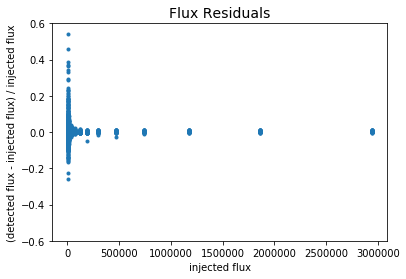

In [28]:
plt.plot(flux_array[0], (flux_array[1] - flux_array[0]) / flux_array[0], '.')
plt.xlabel('injected flux', size=10)
plt.ylabel('(detected flux - injected flux) / injected flux', size=10)
plt.ylim(-0.6, 0.6)
plt.title('Flux Residuals', size=14)

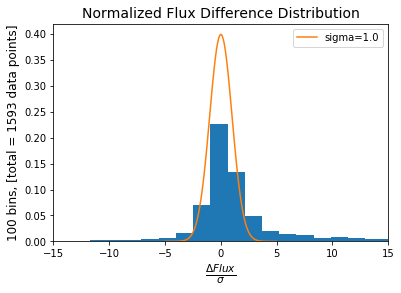

In [34]:
delta_flux = (flux_array[1] - flux_array[0]) / flux_array[2]
delta_flux = delta_flux.reshape(-1,1)

plt.figure()

# plot the distribution of the data
plt.hist(delta_flux, density=True, bins=100, align='mid')
plt.title(r'Normalized Flux Difference Distribution', size=14)
plt.xlim(-20, 20)

# plot a standard normal distribuiton
rv10 = stats.norm(loc=0., scale=1.0)
x = np.arange(-5,5.1,0.1)
plt.plot(x, rv10.pdf(x), label='sigma=1.0')
plt.xlabel(r'$\frac{\Delta Flux}{\sigma}$', size=15)
plt.ylabel('{} bins, [total = {} data points]'.format(100, len(delta_flux)), size=12)
plt.xlim(-15, 15)
plt.legend()

In [52]:
table_dir = './'
eff_table_name = 'eff_perfect_25_offset.csv'

In [57]:
efficiency_table = pd.DataFrame(
    {'fake_mag': injected_mag_array, 'eff_host_16-18': efficiency_array[0],
     'eff_host_18-20': efficiency_array[1], 'eff_host_20-21': efficiency_array[2],
     'eff_host_21-22': efficiency_array[3], 'eff_host_22-23': efficiency_array[4],
     'eff_host_23-24': efficiency_array[5]}
)

In [58]:
# save efficiency to a table
efficiency_table.to_csv(os.path.join(table_dir, eff_table_name), index=False)